In [1]:
import os
import numpy as np
from omegaconf import OmegaConf

import torch
from torchtnt.utils.device import copy_data_to_device
from torchvision.transforms.functional import resize, normalize

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.metrics import average_precision_score

from model import Model
from dataset import *

dataset  = "CELEBA"
root = "./experiments/celeba_linear"
device = "cuda:0"

with open(f"{root}/.hydra/config.yaml", "r") as f:
    cfg = OmegaConf.load(f)

In [2]:
trainloader = get_loader(dataset=dataset,
                         split="train",
                         img_size=cfg.general.img_size,
                         batch_size=cfg.train.batch_size,
                         num_workers=cfg.train.num_workers,
                         pin_memory=cfg.train.pin_memory,
                         persistent_workers=cfg.val.persistent_workers,)

testloader = get_loader(dataset=dataset,
                        split="test",
                        img_size=cfg.general.img_size,
                        batch_size=cfg.val.batch_size,
                        num_workers=cfg.train.num_workers,
                        pin_memory=cfg.train.pin_memory,
                        persistent_workers=cfg.val.persistent_workers,)

CELEBA
CELEBA


# Load CLIP

In [3]:
import clip

#clip.available_models()
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.to(device).eval()
input_resolution = clip_model.visual.input_resolution
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Load our model

In [5]:
module = Model(
    dim_in=cfg.model.dim_in,
    dim_out=cfg.model.dim_out,
    backbone=cfg.model.backbone,
    kernel=cfg.model.kernel,
    activation=torch.nn.functional.leaky_relu,
    alpha=cfg.train.loss_coefs.alpha,
    beta=cfg.train.loss_coefs.beta,
    device=device,
).to(device)

state_dict = torch.load(os.path.join(root, "state_dict.pt"), map_location="cpu")
module.load_state_dict(state_dict)

/tmp/ipykernel_5711/1406260656.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(root, "state_dict.pt"), map_location="cpu")


<All keys matched successfully>

In [29]:
module.forget()
for data in trainloader:
    data = copy_data_to_device(data, device=device)
    with torch.no_grad():
        output = module(data)
module.update_minterms()
module._minterms = torch.stack(module._minterms, dim=0)
module._minterm_evecs = torch.cat(module._minterm_evecs, dim=0)

In [ ]:
import seaborn as sns
plt.figure()
sns.heatmap(torch.square((module._minterm_vecs @ module._minterm_vecs.T).cpu()))

In [34]:
embeddings = []
images = []
labels = []
for data in testloader:
    data = copy_data_to_device(data, device=device)
    images.append(data.images)
    labels.append(data.labels)
    with torch.no_grad():
        embeddings.append(module.embed(data)[0])
embeddings = torch.cat(embeddings, dim=0)
images = torch.cat(images, dim=0)
labels = torch.cat(labels)

In [139]:
query = "not Male and Wearing_Hat and Eyeglasses"
nl_query = "not a male wearing a hat and eyeglasses"

literals = [l.strip() for l in query.split("and")]

pos_literals = [l for l in literals if "not" not in l]
neg_literals = [l.replace("not", "").strip() for l in literals if "not" in l]

print(pos_literals)
print(neg_literals)

pos_idx = [testloader.dataset.class_to_idx[l] for l in pos_literals]
neg_idx = [testloader.dataset.class_to_idx[l] for l in neg_literals]

target = torch.logical_and((labels[:,pos_idx] == 1).all(-1), (labels[:,neg_idx] == 0).all(-1))

['Wearing_Hat', 'Eyeglasses']
['Male']


In [140]:
masks = [module._minterms[:,idx] == 1 for idx in pos_idx]
masks.extend([module._minterms[:,idx] == 0 for idx in neg_idx])

mask = masks[0]
for i in range(len(masks)):
    mask = torch.logical_and(mask, masks[i])
    
projection = module._minterm_evecs[mask].T @ module._minterm_evecs[mask]

p = torch.einsum(
    "bi,ij,bj->b",
    F.normalize(embeddings, dim=-1, p=2),
    projection,
    F.normalize(embeddings, dim=-1, p=2)
)
idx = torch.argsort(p, descending=True)

ap = average_precision_score(target.cpu(), p.cpu())
precision = target[idx[:10]].sum() / 10
print(f"AP = {ap}")
print(f"Precision@10 = {precision}")

AP = 0.13241133037135183
Precision@10 = 0.20000000298023224


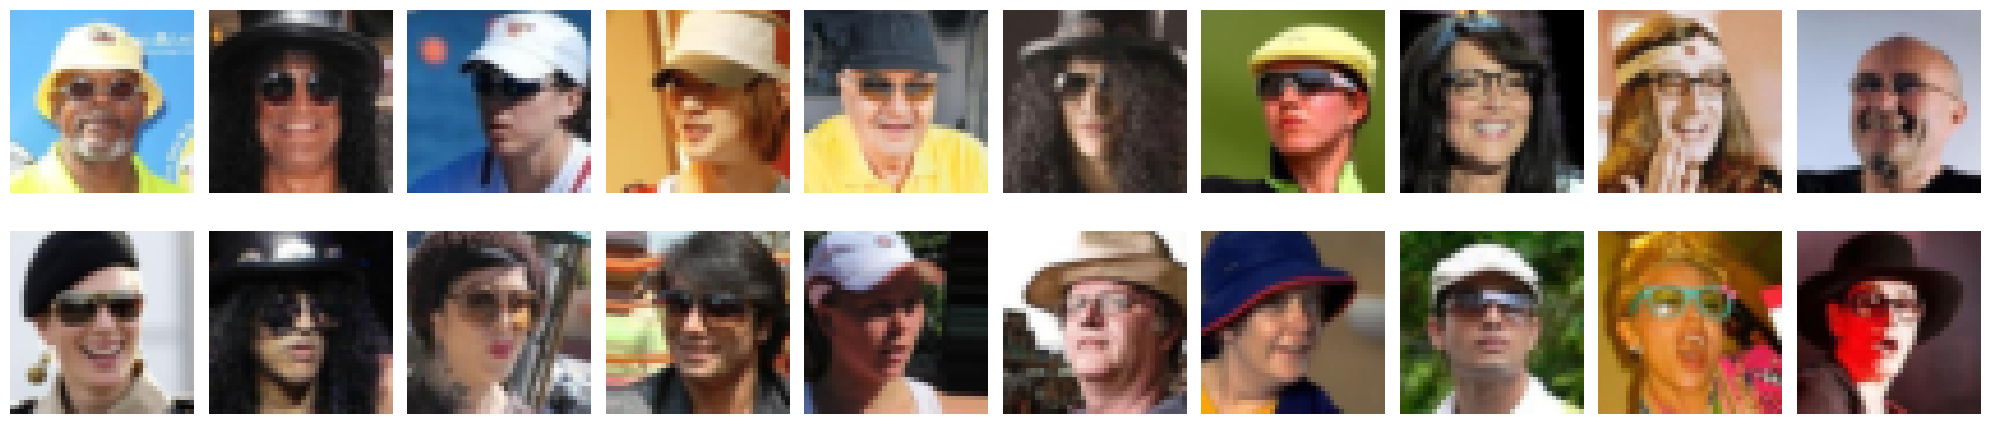

In [141]:
n = 20
fig = plt.figure(figsize=(20,5))
for i in range(n):
    plt.subplot(2,n//2,i+1)
    plt.imshow(images[idx[i]].permute(1,2,0).cpu())
    plt.axis("off")
plt.tight_layout()
fig.savefig(f"{query}_ours.png")

# CLIP retrieval

In [70]:
clip_img_embeddings = []
for data in testloader:
    data = copy_data_to_device(data, device=device)
    with torch.no_grad():
        preprocessed = resize(data.images, 224)
        preprocessed = normalize(preprocessed,
                                 mean=(0.48145466, 0.4578275, 0.40821073),
                                 std=(0.26862954, 0.26130258, 0.27577711))
        clip_img_embeddings.append(clip_model.encode_image(preprocessed).float())
clip_img_embeddings = torch.cat(clip_img_embeddings, dim=0)

In [142]:
with torch.no_grad():
    text_tokens = clip.tokenize([nl_query]).to(device)
    clip_text_embedding = clip_model.encode_text(text_tokens).float()

clip_img_embeddings /= clip_img_embeddings.norm(dim=-1, keepdim=True)
clip_text_embedding /= clip_text_embedding.norm(dim=-1, keepdim=True)
similarity = (clip_text_embedding @ clip_img_embeddings.T).squeeze()
idx = torch.argsort(similarity.squeeze(), descending=True) 

ap = average_precision_score(target.cpu(), similarity.cpu())
precision = target[idx[:10]].sum() / 10
print(f"AP = {ap}")
print(f"Precision@10 = {precision}")

AP = 0.0167905401520551
Precision@10 = 0.0


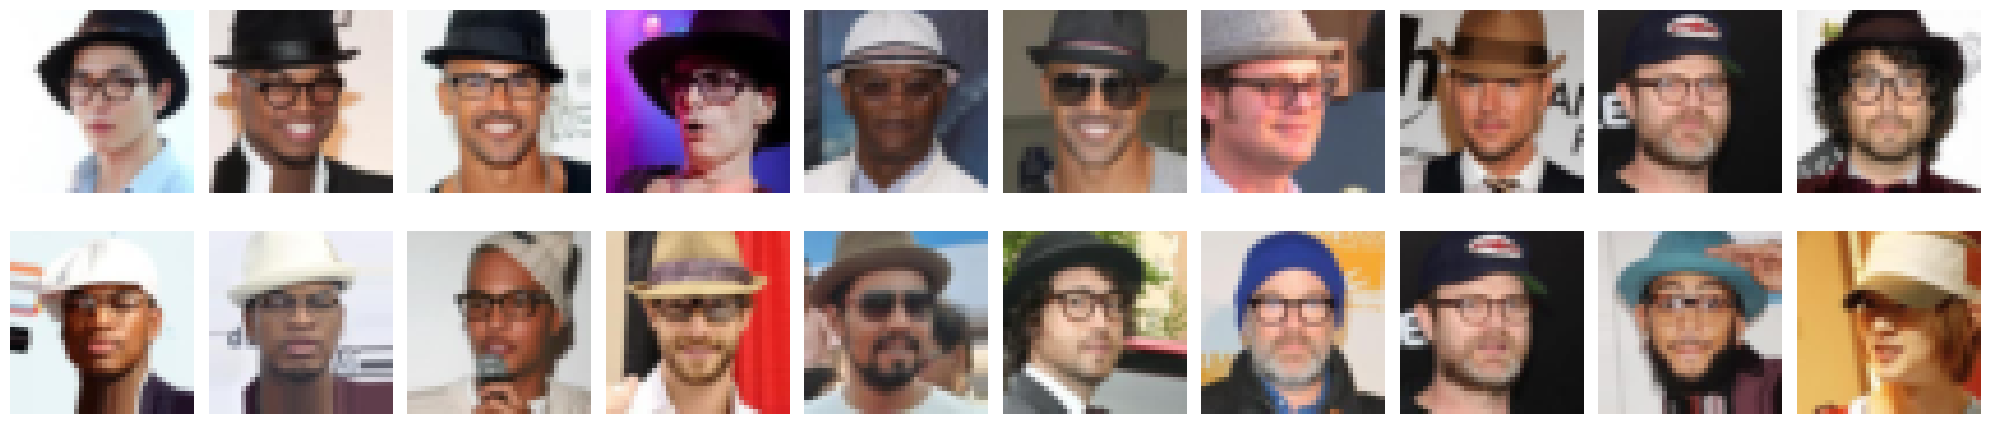

In [143]:
n = 20
fig = plt.figure(figsize=(20,5))
for i in range(n):
    plt.subplot(2,n//2,i+1)
    plt.imshow(images[idx[i]].permute(1,2,0).cpu())
    plt.axis("off")
plt.tight_layout()
fig.savefig(f"{nl_query}_clip.png")